# Introduction

Do not spend too much time trying to get very tiny metrics improvement. Once you have a model with a correct predictive power, you should better spend time explaining your data cleaning & preparation pipeline as well as explanations & visualizations of the results.

The goal is to see your fit with our company culture & engineering needs, spending 50h on an over-complicated approach will not give you bonus points compared to a simple, yet effective, to-the-point solution.

## About the data

For this project you will be working on Wikipedia articles. 
   
The goal of this project is to develop :

* A scraper that is able to retrieve wikipedia articles from 10 different categories of your choice (i.e. Sports, Politics, etc...)
* A model that is able to **classify previously unseen Wikipedia articles** based on the categories you extracted earlier. 

Feel free to use any available library you would need, but beware of re-using someone else's code without mentionning it!

## Deliverable

The end-goal is to deliver us a zip file containing:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work
* A Dockerfile which defines a container for the project. The container should handle everything (download the data, run the code, etc...). When running the container it should expose the jupyter notebook on one port and expose a Flask API on another one. The Flask app contains two endpoints:
  - One for scraping the data and training the model
  - One for querying the last trained model with an article of our choice in the dataset
* A README.md which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* Any necessary .py, .sh or other files needed to run your code.

# Libraries Loading

In [1]:
!pip install transformers
!pip install mlxtend --upgrade --no-deps

     |████████████████████████████████| 1.1MB 5.6MB/s 
     |████████████████████████████████| 3.0MB 30.7MB/s 
     |████████████████████████████████| 890kB 54.0MB/s 
     |████████████████████████████████| 1.1MB 54.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=1b4cceb68c04da15a5f33e9ae9a418b0501aefafddf89535ca7293af0d0022e6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.3MB 5.2MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [2]:
import requests
import random
from bs4 import BeautifulSoup
import re
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, BertForSequenceClassification, AdamW, BertConfig
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import time
import datetime
from sklearn.metrics import classification_report
import seaborn as sns
from queue import Queue, Empty
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [3]:
random.seed(29)
np.random.seed(29)
torch.manual_seed(29)
torch.cuda.manual_seed_all(29)

# Data Preparation & Cleaning

## DataFrame

The title is probably not needed because I will use the content for the classification but maybe in a future implementation it could be used to improve the classification.

In [4]:
df = pd.DataFrame(columns=["title", "content","category"])

## Scrape data
This approach is based on :
* https://levelup.gitconnected.com/two-simple-ways-to-scrape-text-from-wikipedia-in-python-9ce07426579b
* https://www.freecodecamp.org/news/scraping-wikipedia-articles-with-python/

Implementation to scrape data from wikipedia page (title and content). The script starts from a given page and it continues recursively to scrape pages that are related to the initial one (links). The script ends when it reaches a given number of pages (e.g. 10).

Get Wikipedia articles given seed URLs (it can work with a single seed or multi seeds). This approach is very simple and can be extended with more inspections to the links (e.g. no images, no category pages, etc.). I did not use a specific library because for this task I think it is enough to have a simple approach which can do the minimum (I did want to use the time to learn a new library to do this simple scraping) but in a future implementation, it could be good to use https://scrapy.org/ an open-source and collaborative framework for extracting the data you need from websites. 

At the moment this scraping is quite slow but the speed is something that can be solved in a second step e.g. with multithreading or using the Wikipedia API (https://pypi.org/project/wikipedia/).

Moreover, this implementation has many overhead e.g. an article could be processed multiple times. To improve this a big list should be created and each page should be confronted with every category.

### Single threading scraping

In [5]:
def get_links(urls,category,num,max_num):
    # use global dataframe
    global df
    
    while len(urls)>0 and num <= max_num:
    
        # get random link from urls (in this way we are not going deeper and deeper but randomly)
        url = random.choice(urls)
        
        response = requests.get(url=url)
        soup = BeautifulSoup(response.content, 'html.parser')
        regex = re.compile(r'/wiki/.+')

        # Get article categories
        categories = soup.find(id="mw-normal-catlinks")

        # Check if page contains categories (e.g. an image page does not have this information)
        if categories is None:
            continue
        
        categories = categories.select('li a')
        # Continue only if articles contains the given category
        if any(category in cat.text.lower() for cat in categories):
            
            # Get article title
            title = soup.find(id="firstHeading").text

            # Get article content
            text = ''
            for paragraph in soup.find_all('p'):
                text += paragraph.text
                
            # Drop footnote superscripts in brackets and Replace ‘\n’ (a new line) with ‘’ (an empty string) 
            text = re.sub(r'\[.*?\]+', '', text)
            text = text.replace('\n', '')

            # Add article to dataframe
            df = df.append({
                "title": title,
                "content": text,
                "category": category
            },ignore_index=True)
            
            num += 1
            # print(category+" "+title)

            # Scrape other pages from links
            # Get all the links
            links = soup.find(id="bodyContent").find_all("a",{'href': True})
            
            
            for link in links:
                # Only interested in other wiki articles (remove external links and images)
                if re.match(regex,link.get('href')): 
                    urls.append("https://en.wikipedia.org" + link.get('href'))
                    
        

In [6]:
# t0 = time.time()
# get_links(["https://en.wikipedia.org/wiki/Sport"],"sport",0,10) 
# print(time.time()-t0)

In [7]:
#get_links(["https://en.wikipedia.org/wiki/Economy"],"economy",0,10)
#get_links(["https://en.wikipedia.org/wiki/Engineering"],"engineering",0,10)
#get_links(["https://en.wikipedia.org/wiki/History"],"history",0,10)
#get_links(["https://en.wikipedia.org/wiki/Philosophy"],"philosophy",0,10)
#get_links(["https://en.wikipedia.org/wiki/Politics"],"politics",0,10)
#get_links(["https://en.wikipedia.org/wiki/Religion"],"religion",0,10)
#get_links(["https://en.wikipedia.org/wiki/Universe"],"universe",0,10)
#get_links(["https://en.wikipedia.org/wiki/Law"],"law",0,10)
#get_links(["https://en.wikipedia.org/wiki/Culture"],"culture",0,10)

### Multithreading version scraping

MultiThread version (is not my best piece of code but it works and it is much faster. The threadpoolexecutor shotdown and the counting mechanism should be improved). 

Single thread for 10 articles: 11.07 secs
Multi threads for 10 articles: 2.80 secs

Based on https://edmundmartin.com/multi-threaded-crawler-in-python/

In [8]:
class MultiThreadScraper:
    
    def __init__(self,base_urls,category,max_num):
        self.category = category
        self.max_num = max_num
        self.pool = ThreadPoolExecutor(max_workers=6)
        self.scraped_pages = set([])
        self.to_crawl = Queue()
        # add base urls
        for url in base_urls:
            self.to_crawl.put(url)
        self.num = 0
        
    def parse_links(self,html):
        global df
        soup = BeautifulSoup(html, 'html.parser')
        regex = re.compile(r'/wiki/.+')

        # Get article categories
        categories = soup.find(id="mw-normal-catlinks")

        # Check if page contains categories (e.g. an image page does not have this information)
        if categories is None:
            return
        
        categories = categories.select('li a')
        # Continue only if articles contains the given category
        if any(self.category in cat.text.lower() for cat in categories):
            
            # Get article title
            title = soup.find(id="firstHeading").text

            # Get article content
            text = ''
            for paragraph in soup.find_all('p'):
                text += paragraph.text
                
            # Drop footnote superscripts in brackets and Replace ‘\n’ (a new line) with ‘’ (an empty string) 
            text = re.sub(r'\[.*?\]+', '', text)
            text = text.replace('\n', '')
            
            self.num += 1
            
            # Add article to dataframe
            df = df.append({
                "title": title,
                "content": text,
                "category": self.category
            },ignore_index=True)
            
            
            #print(self.category+" "+title)

            # Scrape other pages from links
            # Get all the links
            links = soup.find(id="bodyContent").find_all("a",{'href': True})
            
            
            for link in links:
                # Only interested in other wiki articles (remove external links and images)
                if re.match(regex,link.get('href')): 
                    self.to_crawl.put("https://en.wikipedia.org" + link.get('href'))
                    
    def post_scrape_callback(self,res):
        result = res.result()
        if result and result.status_code == 200 and self.num<self.max_num:
            self.parse_links(result.text)
            
    def scrape_page(self,url):
        try:
            res = requests.get(url, timeout=(3, 30))
            return res
        except requests.RequestException:
            return
        
    def run_scraper(self):
        while True:
            try:
                target_url = self.to_crawl.get(timeout=60)
                # return if reached target number of articles
                if self.num>self.max_num:
                    self.pool.shutdown(wait=False)
                    return
                if target_url not in self.scraped_pages:
                    # print("Scraping URL: {}".format(target_url))
                    self.scraped_pages.add(target_url)
                    job = self.pool.submit(self.scrape_page, target_url)
                    job.add_done_callback(self.post_scrape_callback)
            except Empty:
                return
            except Exception as e:
                print(e)
                continue

In [9]:
t0 = time.time()
s = MultiThreadScraper(["https://en.wikipedia.org/wiki/History"],"history",50)
s.run_scraper()
print(time.time()-t0)

29.4187593460083


In [10]:
t0 = time.time()
s = MultiThreadScraper(["https://en.wikipedia.org/wiki/Sport"],"sport",50)
s.run_scraper()
print(time.time()-t0)

78.31261277198792


In [11]:
t0 = time.time()
s = MultiThreadScraper(["https://en.wikipedia.org/wiki/Economy"],"economy",50)
s.run_scraper()
print(time.time()-t0)

349.84067487716675


In [12]:
t0 = time.time()
s = MultiThreadScraper(["https://en.wikipedia.org/wiki/Engineering"],"engineering",50)
s.run_scraper()
print(time.time()-t0)

61.799601554870605


In [13]:
t0 = time.time()
s = MultiThreadScraper(["https://en.wikipedia.org/wiki/Philosophy"],"philosophy",50)
s.run_scraper()
print(time.time()-t0)

35.488691329956055


In [14]:
t0 = time.time()
s = MultiThreadScraper(["https://en.wikipedia.org/wiki/Politics"],"politics",50)
s.run_scraper()
print(time.time()-t0)

164.418842792511


In [15]:
t0 = time.time()
s = MultiThreadScraper(["https://en.wikipedia.org/wiki/Religion"],"religion",50)
s.run_scraper()
print(time.time()-t0)

115.60599422454834


In [16]:
t0 = time.time()
s = MultiThreadScraper(["https://en.wikipedia.org/wiki/Food"],"food",50)
s.run_scraper()
print(time.time()-t0)

138.70524668693542


In [17]:
t0 = time.time()
s = MultiThreadScraper(["https://en.wikipedia.org/wiki/Law"],"law",50)
s.run_scraper()
print(time.time()-t0)

63.850114822387695


In [18]:
t0 = time.time()
s = MultiThreadScraper(["https://en.wikipedia.org/wiki/Culture"],"culture",50)
s.run_scraper()
print(time.time()-t0)

134.94718074798584


!!!!!! It still take quite a long time to complete the scraping... on Google Colab it takes around 20 minutes.

In [19]:
df.describe()

,title,content,category
count,467,467,467
unique,445,445,10
top,Contract,Traditions by regionTraditions by schoolTradit...,philosophy
freq,3,3,49


Save dataframe (for later use if needed)

In [20]:
df.to_pickle("./dataframe.pkl")

In [21]:
#df = pd.read_pickle("./dataframe.pkl")

## Preprocessing data

This approach is based on :
* https://github.com/ArmandDS/bert_for_long_text/blob/master/final_bert_long_docs.ipynb

Clean and analyse data before training the choosen model for text classification.

### All articles

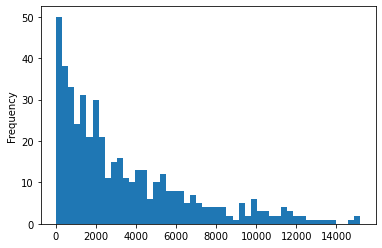

In [22]:
df.content.apply(lambda x:len(x.split())).plot(kind='hist',bins=50)

### Articles with more than 2000 words

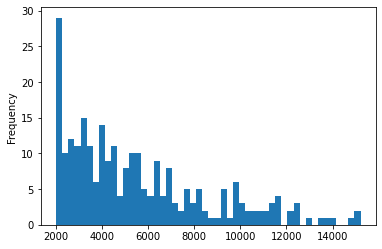

In [23]:
df.content[df.content.apply(lambda x:len(x.split()) > 2000)].apply(lambda x:len(x.split())).plot(kind='hist',bins=50)

### Articles with less than 2000 words

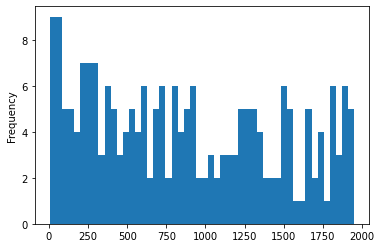

In [24]:
df.content[df.content.apply(lambda x:len(x.split()) < 2000)].apply(lambda x:len(x.split())).plot(kind='hist',bins=50)

Number of articles below and above 500 words

In [25]:
df.content[df.content.apply(lambda x:len(x.split()) < 500)].count()

74

In [26]:
df.content[df.content.apply(lambda x:len(x.split()) > 500)].count()

393

In [27]:
(78/df.content.count())*100

16.70235546038544

In [28]:
(386/df.content.count())*100

82.65524625267666

Info about articles length

In [29]:
df['len'] = df.content.apply(lambda x:len(x.split()))
df.describe()

,len
count,467.00000
mean,3420.61242
std,3299.73118
min,6.00000
25%,883.50000
50%,2195.00000
75%,5099.50000
max,15209.00000


The articles are quite long in general (up to 12000). The mean is 3452 words. The 83% are above 500 words.

### Data cleaning

Keep only content and category and rename them to text and label

In [30]:
df = df[['content','category']].rename(columns = {"content":"text","category":"label"})

Analyse size of the different categories

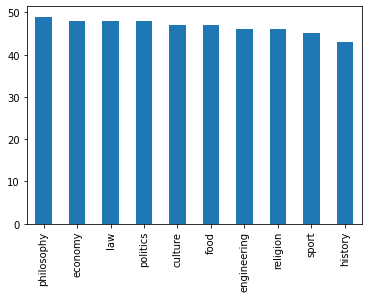

In [31]:
df['label'].value_counts().plot(kind='bar')

Pretty much all the categories reach the target number of articles (50)

Encode label to integer values

In [32]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df.head()

,text,label
0,"—George SantayanaHistory (from Greek ἱστορία, ...",4
1,Jorge Agustín Nicolás Ruiz de Santayana y Borr...,4
2,Herodotus (/hɪˈrɒdətəs/; Ancient Greek: Ἡρόδοτ...,4
3,"Human history, also known as world history, is...",4
4,Historical source (also known as historical ma...,4


Check if there are 10 classes as given in the assignment

In [33]:
assert(len(np.unique(df['label']))==10)

Additional cleaning to remove apostrophes and tabs

In [34]:
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)    
  return text

In [35]:
df['text']  = df.text.apply(clean_txt)
df.head()

,text,label
0,George SantayanaHistory from Greek ἱστορία hi...,4
1,Jorge Agustín Nicolás Ruiz de Santayana y Borr...,4
2,Herodotus hɪˈrɒdətəs Ancient Greek Ἡρόδοτος Hē...,4
3,Human history also known as world history is t...,4
4,Historical source also known as historical mat...,4


Stratified train val test split

In [36]:
train, test = train_test_split(df,stratify=df.label, test_size=0.2)
train, val = train_test_split(train,stratify=train.label, test_size=0.2)

Reset indices

In [37]:
train.reset_index(inplace=True)
val.reset_index(inplace=True)
test.reset_index(inplace=True)

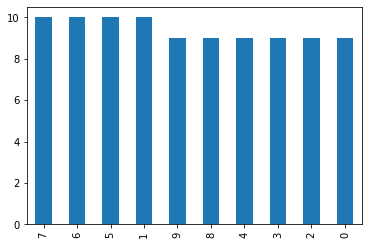

In [38]:
test['label'].value_counts().plot(kind='bar')

I am not an expert in NLP and I have little experience with it but as I keep up with research paper I know that BERT (https://arxiv.org/abs/1810.04805) was used a lot in the last years. Moreover, it can "be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks". This is exactly what I need for this task because for sure I will not scrape thousands of pages but only a small dataset.

For sure there are other techniques that could perform better but BERT comes with Pytorch transformers which are simple to use and adapt for a specific task.

## Bert data preparation
This approach is based on :
* https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/#:~:text=%E2%80%9CBERT%20stands%20for%20Bidirectional%20Encoder,both%20left%20and%20right%20context
* https://github.com/huggingface/transformers
* https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d

Problem with BERT is that it can fit only 510 tokens (much less than Wikipedia articles). Sun et al. (https://arxiv.org/abs/1905.05583) looked into this problem (text classification with larger text). There are different possibilities for truncation:
* Cut at the beginning and at the end (head+tail)
* Cut at the beginning (head only)
* Cut at the end (tail only)

In their experiments, they proved that the head+tail truncation is the best option. Moreover, they showed that simple techniques (e.g. head only, tail only) outperform smarter methods like hierarchy mean and max (classification of different chunks and then an aggregation with max or mean pooling). 

As in this assignment, I do not need a perfect model I will go with a **head only truncation** which is pretty simple to do and also effective. In an additional phase, this model could be changed to try to improve the classification performance (e.g. perform text summarization before feeding it to BERT, chunk classification and voting system, etc.).

In [39]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased',do_lower_case=True)

In [40]:
tokens_train = tokenizer.batch_encode_plus(train['text'].tolist(),truncation=True,padding=True)
tokens_val = tokenizer.batch_encode_plus(val['text'].tolist(),truncation=True,padding=True)
tokens_test = tokenizer.batch_encode_plus(test['text'].tolist(),truncation=True,padding=True)

In [41]:
# tokens_train[0].tokens

In [42]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train['label'].tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val['label'].tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test['label'].tolist())

### Create datasets

In [43]:
# The batch size is set to 2 instead of 16 ore 32 (suggestion from original paper) 
# because Gooogle Colab GPU cannot fit bigger batches 
#(if a more performant GPU is avialable it should be good to use 16 or 32).

batch_size = 2

#### Train

In [44]:
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#### Val

In [45]:
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

#### Test

In [46]:
# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

# Feature Engineering & Modeling

This is the normal BERT model with an extra single linear layer on top for classification that we will use as a sentence classifier (https://huggingface.co/transformers/model_doc/bert.html#transformers.BertForSequenceClassification).

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Set the corret number fo classes for the classification (in this case 10 output categories)

In [48]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 10,   
    output_attentions = False, 
    output_hidden_states = False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [49]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [50]:
# Check output layers
params = list(model.named_parameters())

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

bert.pooler.dense.weight                                  (768, 768)
bert.pooler.dense.bias                                        (768,)
classifier.weight                                          (10, 768)
classifier.bias                                                (10,)


Optimizer, in the original paper they propose to use one of these lr for fine-tuning learning (5e-5, 4e-5, 3e-5, and 2e-5) and as I do not have time for an hyperparameter search I will use 2e-5.

In [51]:
optimizer = AdamW(model.parameters(), lr = 2e-5)

As I scrape wikipedia to have balanced classes we do not need class weights, if that was the case sklearn.utils.class_weight can help a lot.

Training and evaluation loop based on https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py

In [52]:
# Number of training epochs (authors recommend between 2 and 4). To see how it behave and because it is pretty fast to
# train on a GPU I decided to use more epochs (only the model which achieves the highest val accuracy is kept).
epochs = 10

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

### Helper methods

In [53]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [54]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    
    #  hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Training func

In [55]:
def train(dataloader):
    print("Training...")
    
    # Start time
    t0 = time.time()

    total_loss = 0

    model.train()

    for step, batch in enumerate(dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Elapsed time in mins
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # Clear gradients
        model.zero_grad()        

        # Forward pass
        outputs = model(sent_id,
                    attention_mask=mask, 
                    labels=labels,
                    return_dict=True)
        
        # Get loss on CrossEntropyLoss
        loss = outputs.loss

        total_loss += loss.item()

        loss.backward()

        # Clip the the gradients to 1.0 (exploding gradient)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update lr
        scheduler.step()

    # average loss
    avg_train_loss = total_loss / len(train_dataloader)            
    

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
    return avg_train_loss

### Evaluation func

In [56]:
def evaluate(dataloader):
    print("Validation...")

    t0 = time.time()
    
    total_loss = 0

    # Eval mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    predictions , true_labels = [], []

    for batch in dataloader:
        
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():        
            outputs = model(sent_id, 
                            attention_mask=mask,
                            labels=labels,
                               return_dict=True)
        
        # Logits (before softmax) 
        logits = outputs.logits
        
        # Get loss on CrossEntropyLoss
        loss = outputs.loss

        total_loss += loss.item()
        
        # Put values to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        
        # Predictions and true labels
        predictions.extend(logits)
        true_labels.extend(label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += flat_accuracy(logits, label_ids)

    
    # Average loss
    avg_val_loss = total_loss / len(dataloader)            
    
    # Average accuracy
    avg_val_accuracy = eval_accuracy/len(dataloader)
    
    
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    
    return avg_val_loss, avg_val_accuracy, predictions, true_labels

### Training loop

In [57]:
loss_values = []
loss_val_values = []
accuracy_val_values = []
best_val_acc = 0.0
for epoch in range(0, epochs):
    
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    
    # Train
    avg_train_loss = train(train_dataloader)
    loss_values.append(avg_train_loss)
    
        
    # Validation
    avg_val_loss, avg_val_accuracy, _, _ = evaluate(val_dataloader)
    loss_val_values.append(avg_val_loss)
    accuracy_val_values.append(avg_val_accuracy)
    
    # Save best model
    if avg_val_accuracy > best_val_acc:
        best_val_acc = avg_val_accuracy
        torch.save(model.state_dict(), 'saved_weights.pt')

print("Done")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    149.    Elapsed: 0:00:15.
  Batch    80  of    149.    Elapsed: 0:00:29.
  Batch   120  of    149.    Elapsed: 0:00:44.
  Average training loss: 2.31
  Training epcoh took: 0:00:53
Validation...
  Accuracy: 0.49
  Validation took: 0:00:03
======== Epoch 2 / 10 ========
Training...
  Batch    40  of    149.    Elapsed: 0:00:10.
  Batch    80  of    149.    Elapsed: 0:00:21.
  Batch   120  of    149.    Elapsed: 0:00:31.
  Average training loss: 1.25
  Training epcoh took: 0:00:39
Validation...
  Accuracy: 0.88
  Validation took: 0:00:03
======== Epoch 3 / 10 ========
Training...
  Batch    40  of    149.    Elapsed: 0:00:11.
  Batch    80  of    149.    Elapsed: 0:00:21.
  Batch   120  of    149.    Elapsed: 0:00:32.
  Average training loss: 0.42
  Training epcoh took: 0:00:39
Validation...
  Accuracy: 0.88
  Validation took: 0:00:03
======== Epoch 4 / 10 ========
Training...
  Batch    40  of    149.    Elapsed: 0:00:10.
 

# Results & Visualizations

Plot loss and accuracy of the training

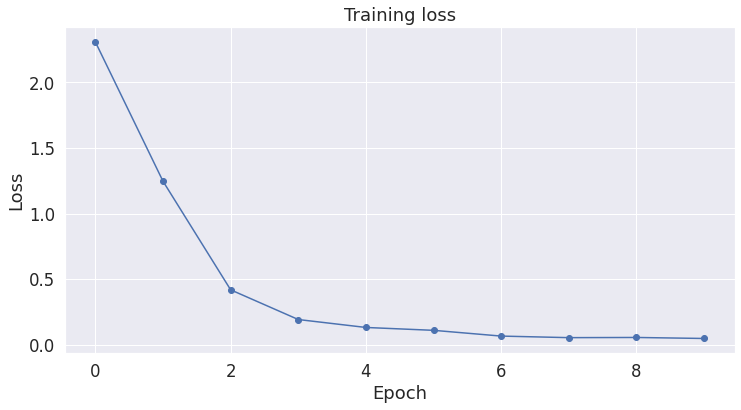

In [58]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

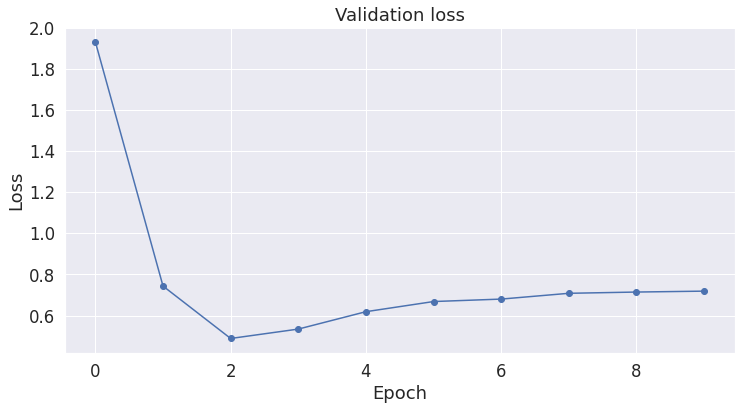

In [59]:
# Plot the learning curve.
plt.plot(loss_val_values, 'b-o')

# Label the plot.
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

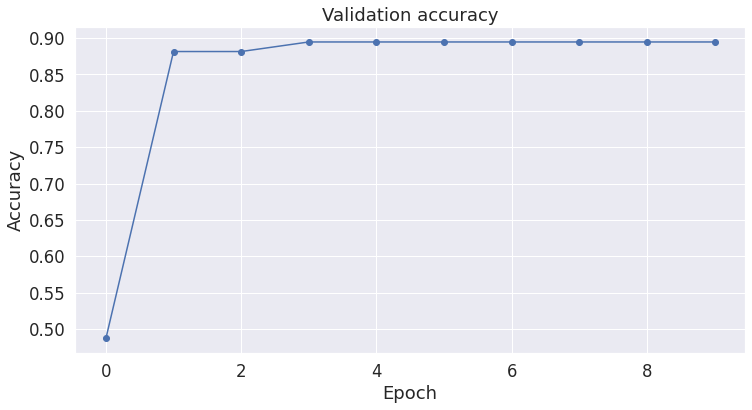

In [60]:
# Plot the learning curve.
plt.plot(accuracy_val_values, 'b-o')

# Label the plot.
plt.title("Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

It seems like the network cannot get better than 89% accuracy (probably it should be better to look at other metrics). Moreover, it starts to overfit after 2 epochs (we can see that the validation loss start to increase while the validation accuracy is stable). Maybe with a smaller/bigger learning rate, the network could get better but as the objective is not to get the best performance I will leave it like that.

### Performance on test set

In [61]:
_, _, predictions, true_labels = evaluate(test_dataloader)
preds = np.argmax(predictions, axis = 1)
print(classification_report(true_labels, preds, target_names=list(label_encoder.classes_)))

Validation...
  Accuracy: 0.88
  Validation took: 0:00:04
              precision    recall  f1-score   support

     culture       0.71      0.56      0.63         9
     economy       0.83      1.00      0.91        10
 engineering       0.90      1.00      0.95         9
        food       1.00      1.00      1.00         9
     history       1.00      0.78      0.88         9
         law       1.00      0.70      0.82        10
  philosophy       0.80      0.80      0.80        10
    politics       0.71      1.00      0.83        10
    religion       1.00      1.00      1.00         9
       sport       1.00      1.00      1.00         9

    accuracy                           0.88        94
   macro avg       0.90      0.88      0.88        94
weighted avg       0.89      0.88      0.88        94



From the classification report on a test set, we can see that also the other metrics (i.e. precision, recall and f1) follow the accuracy. In this case, the accuracy is the same as in the second (best one) on the validation set (88%). For the given small dataset I think this is a pretty good result. 

Probably with a hyperparameters search and maybe a higher batch size (batch size seems to have always an impact on training), which in this case was 2 (for GPU memory limitation), the model could achieve better performance. I read different papers about that but I cannot find them... I am not sure if this assumption is also true for BERT.

The classification report shows the macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label).

If we look more into the f1 score of the different classes we can see that this model have some problems especially with **culture** and **philosophy**.

In [62]:
cm = confusion_matrix(true_labels, preds)

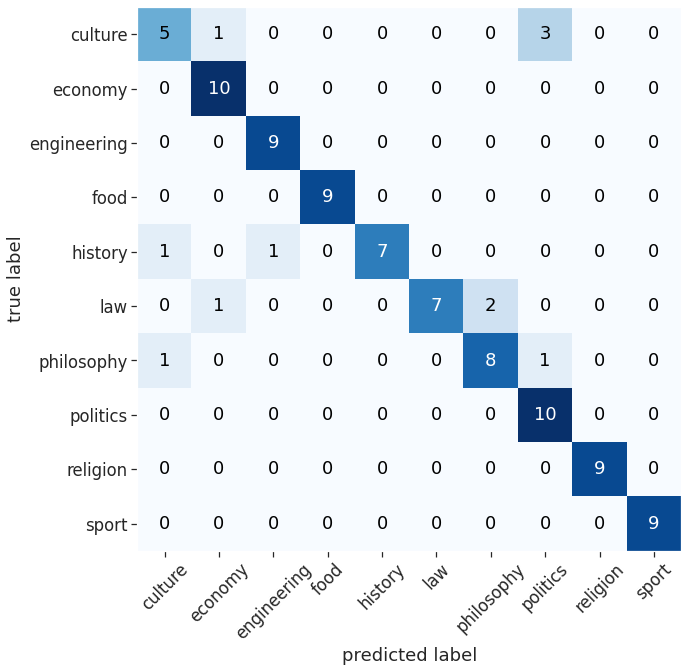

In [66]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=False,
                                show_absolute=True,
                                show_normed=False,
                                figsize=(10, 10),
                                class_names=list(label_encoder.classes_))
plt.show()

If we look at the confusion matrix we can see that the model classifies a few of culture articles into politics. This behaviour was somehow expected as culture and politics articles could be pretty similar (especially if we look at the first 512 tokens). The same happens for other categories, for example, a few of law articles are predicted to be philosophy (they could be pretty similar). To check this assumption, I should look into the dataset and find this miss classification and check their content but for the limited amount of time, I will leave this for another time.